In [3]:
%matplotlib notebook
import json
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from src.main.imu_data_io import load_raw_sensor_data, save_data, check_already_processed
from src.utils.imu_data_visualization import *
from src.utils.tools import *

In [4]:
with open('../config/imu_config.json') as config_file:
    config = json.load(config_file)

raw_data_directory = config['data_paths']['raw_data_directory']
processed_data_directory = config['data_paths']['processed_data_directory']
upsample_frequency = config['resampling']['upsample_frequency']
median_filter_order = config['filtering']['median_filter_order']
gravity_filter_cutoff_hz = config['filtering']['gravity_filter_cutoff_hz']
left_handed_subjects = config['processing_options']['left_handed_subjects']
saving_format = config['saving_options']['file_format']

In [5]:
path = "../data/raw/19"

In [29]:
acc_data, gyro_data = load_raw_sensor_data(path)
print(len(acc_data))
print(calculate_frequency(acc_data))

42755
51.546864853275615


<IPython.core.display.Javascript object>


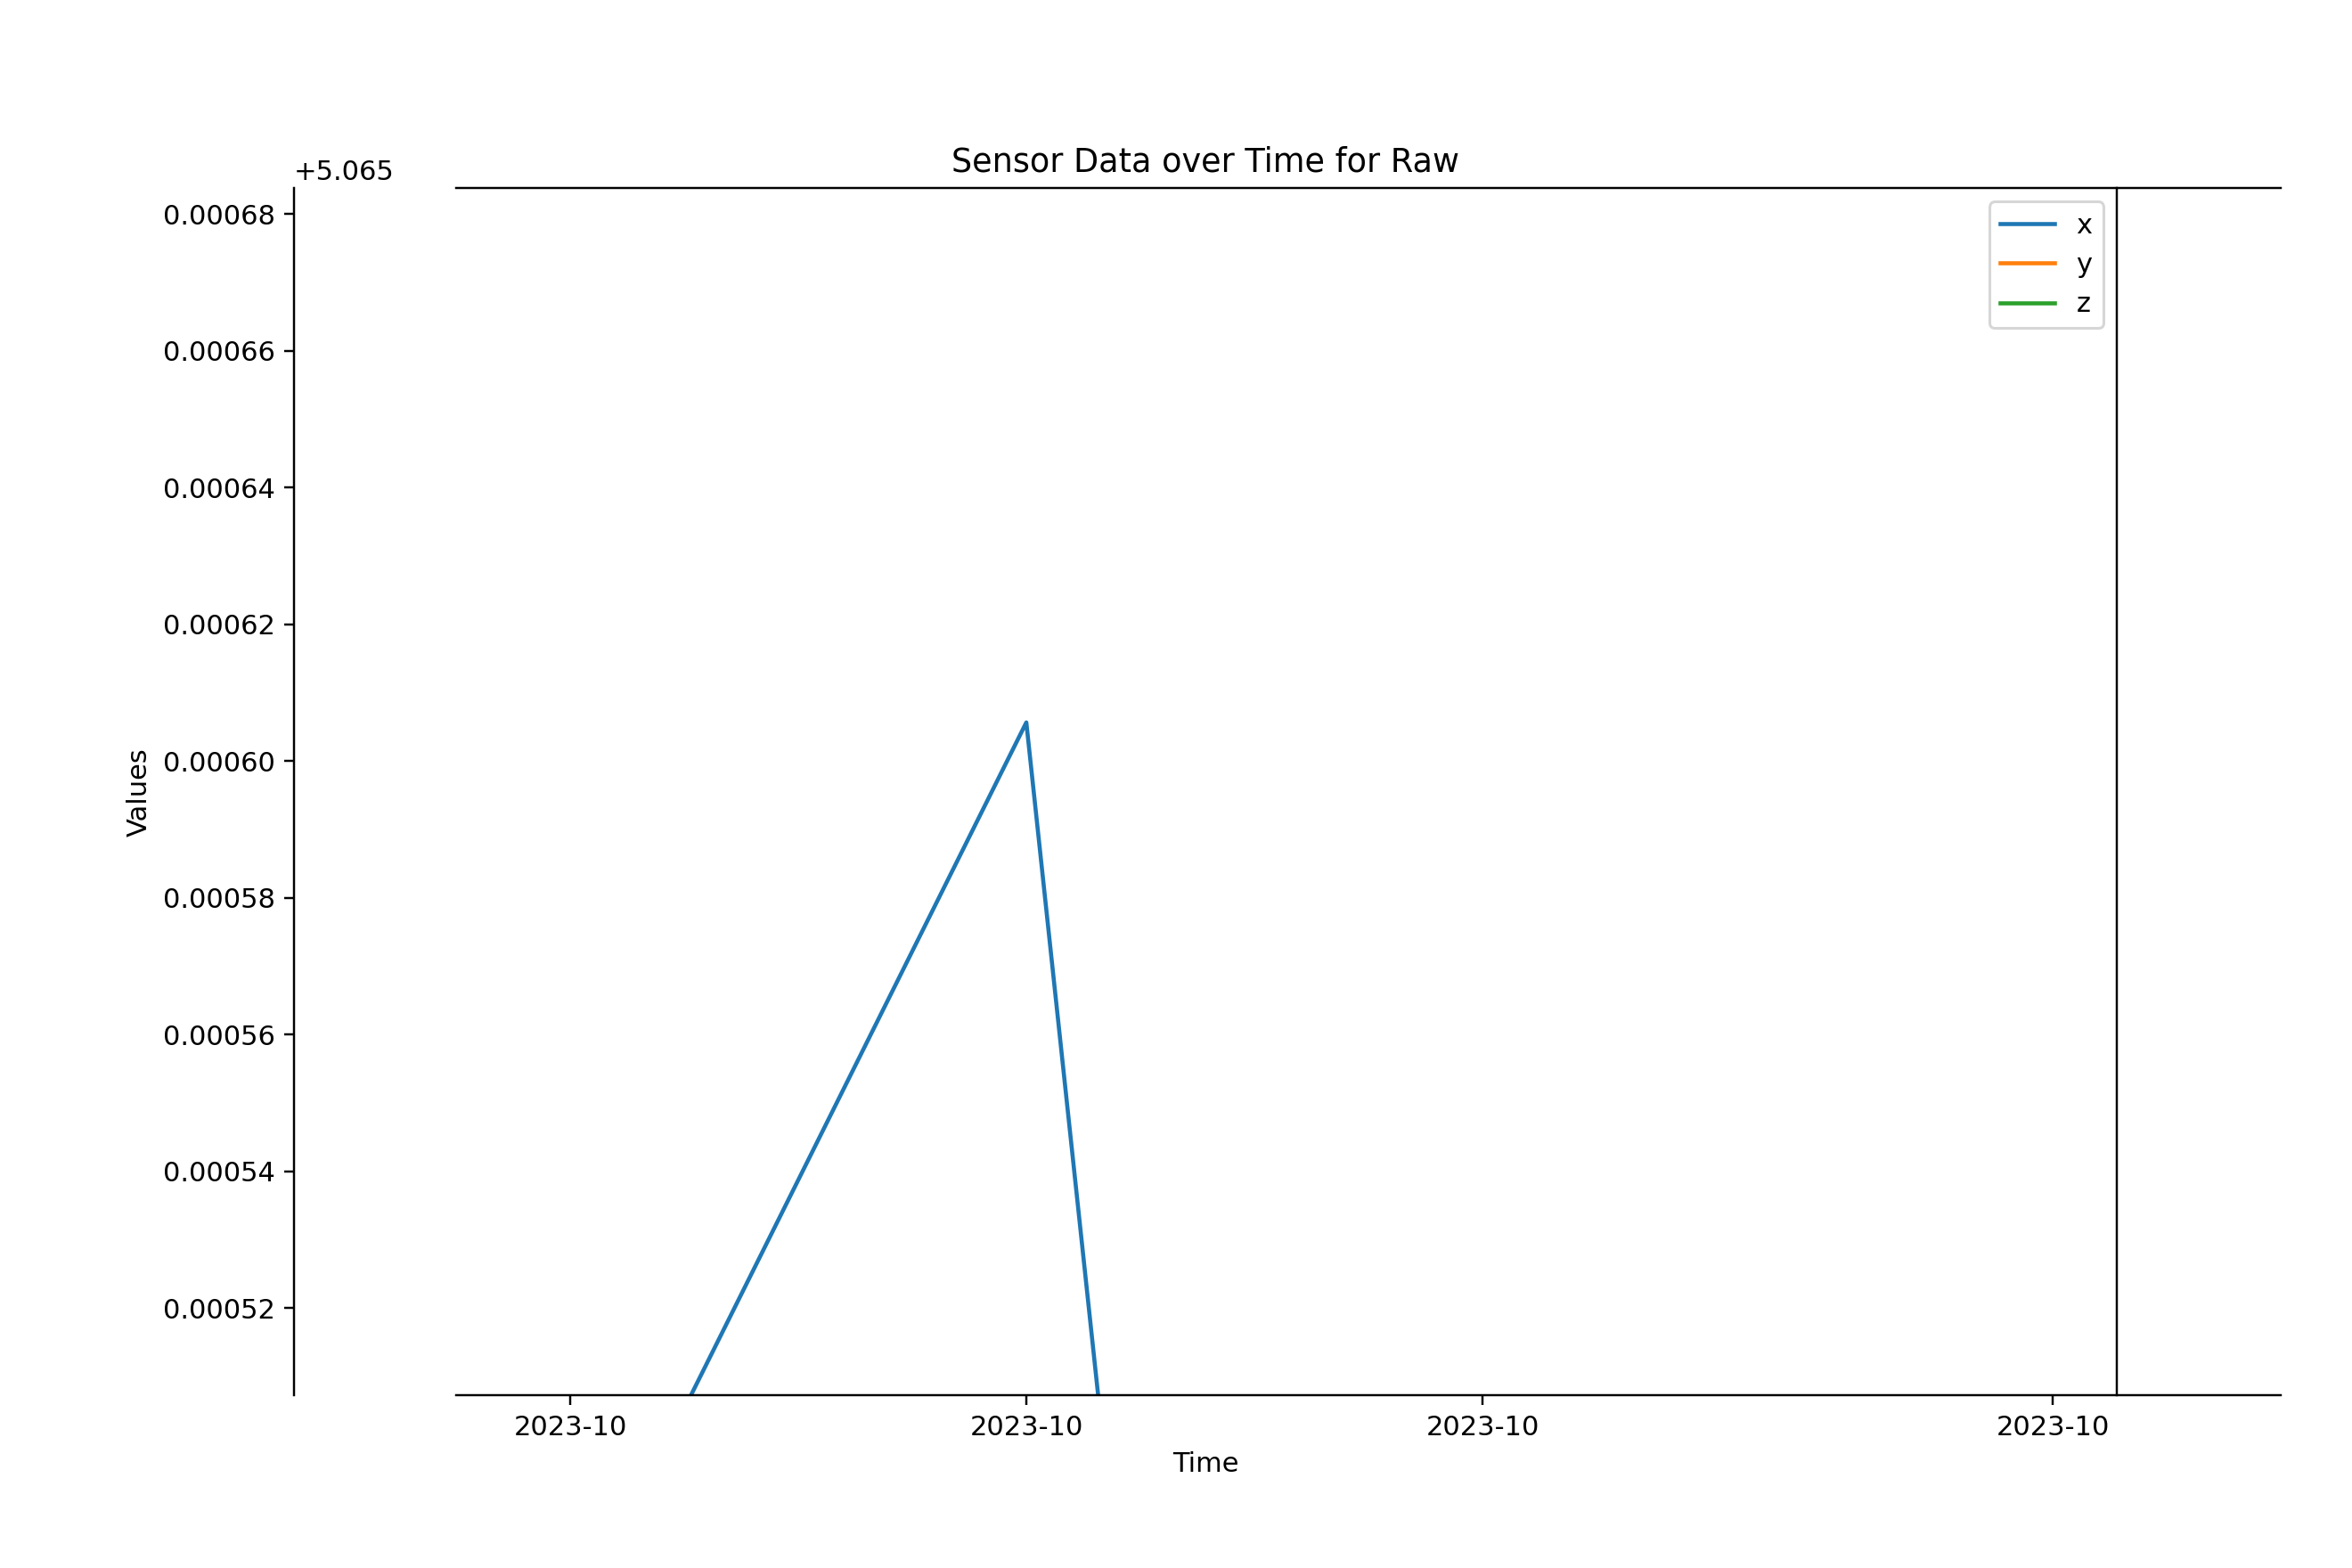

In [32]:
plot_raw_sensor([acc_data],"Raw")

In [7]:
# # δουλέυει κανονικότατα! .302000
# def upsample_sensor_data(sensor_data, target_freq):
#     # Convert timestamp to numeric for interpolation
#     sensor_data['time_numeric'] = pd.to_datetime(sensor_data['time']).astype(np.int64)

#     # Interpolate for each axis
#     interpolated_data = {}
#     for axis in ['x', 'y', 'z']:
#         f = interp1d(sensor_data['time_numeric'], sensor_data[axis], kind='linear', fill_value='extrapolate')
#         interpolated_data[axis] = f(sensor_data['time_numeric'])

#     # Convert back to datetime
#     interpolated_data['time'] = pd.to_datetime(sensor_data['time_numeric'])

#     return pd.DataFrame(interpolated_data)

# def interpolate_to_common_timestamps(sensor_data, common_timestamps):
#     sensor_data['time_numeric'] = pd.to_datetime(sensor_data['time']).astype(np.int64)
#     common_time_numeric = common_timestamps.astype(np.int64)

#     interpolated_data = {}
#     for axis in ['x', 'y', 'z']:
#         f = interp1d(sensor_data['time_numeric'], sensor_data[axis], kind='linear', fill_value='extrapolate')
#         interpolated_data[axis] = f(common_time_numeric)

#     interpolated_data['time'] = common_timestamps

#     return pd.DataFrame(interpolated_data)

# def upsample_and_sync(acc_data, gyro_data, target_freq):
#     # Upsample accelerometer data
#     acc_resampled = upsample_sensor_data(acc_data, target_freq)
#     plot_raw_sensor([acc_resampled], "Resampled inbetween step")
#     print(calculate_frequency(acc_resampled))
#     # Upsample gyroscope data
#     gyro_resampled = upsample_sensor_data(gyro_data, target_freq)

#     # Generate new common timestamps
#     start_time = max(acc_resampled['time'].iloc[0], gyro_resampled['time'].iloc[0])
#     end_time = min(acc_resampled['time'].iloc[-1], gyro_resampled['time'].iloc[-1])
#     common_timestamps = pd.date_range(start=start_time, end=end_time, freq=f'{1000/target_freq}ms')
    
#     # Interpolate accelerometer and gyroscope data to common timestamps
#     acc_resampled = interpolate_to_common_timestamps(acc_resampled, common_timestamps)
#     gyro_resampled = interpolate_to_common_timestamps(gyro_resampled, common_timestamps)

#     return acc_resampled, gyro_resampled

In [14]:
# δουλεύει κομπλε .302000
def upsample_sensor_data(sensor_data, target_freq):
    # Ensure the time column is in datetime format
    sensor_data['time'] = pd.to_datetime(sensor_data['time'])

    # Determine the range of the timestamps
    time_range = pd.date_range(start=sensor_data['time'].min(), 
                               end=sensor_data['time'].max(), 
                               freq=pd.Timedelta(seconds=1/target_freq))

    # Convert timestamp to numeric for interpolation
    sensor_data['time_numeric'] = sensor_data['time'].astype(np.int64)
    time_range_numeric = time_range.astype(np.int64)

    # Interpolate for each axis
    interpolated_data = {}
    for axis in ['x', 'y', 'z']:
        f = interp1d(sensor_data['time_numeric'], sensor_data[axis], kind='linear', fill_value='extrapolate')
        interpolated_data[axis] = f(time_range_numeric)

    # Convert numeric times back to timestamps
    interpolated_data['time'] = time_range

    return pd.DataFrame(interpolated_data)


def upsample_and_sync(acc_data, gyro_data, target_freq):
    # Upsample accelerometer data
    acc_resampled = upsample_sensor_data(acc_data, target_freq)
    
    
    plot_raw_sensor([acc_resampled], "Resampled inbetween step")
    print(calculate_frequency(acc_resampled))
    
    
    
    # Upsample gyroscope data
    gyro_resampled = upsample_sensor_data(gyro_data, target_freq)

    # Synchronize the timestamps
    # Since both are upsampled to the same frequency, we can just align their timestamps
    common_start_time = max(acc_resampled['time'].iloc[0], gyro_resampled['time'].iloc[0])
    common_end_time = min(acc_resampled['time'].iloc[-1], gyro_resampled['time'].iloc[-1])

    # Trim the data to the common timeframe
    acc_resampled = acc_resampled[(acc_resampled['time'] >= common_start_time) & (acc_resampled['time'] <= common_end_time)]
    gyro_resampled = gyro_resampled[(gyro_resampled['time'] >= common_start_time) & (gyro_resampled['time'] <= common_end_time)]

    return acc_resampled, gyro_resampled

In [42]:
# first try to first sync then resample.-->same result ειναι οκ!! .302000 
def interpolate_to_common_timestamps(sensor_data, common_time_range):
    # Convert timestamp to numeric for interpolation
    sensor_data['time_numeric'] = sensor_data['time'].astype(np.int64)
    common_time_range_numeric = common_time_range.astype(np.int64)

    # Interpolate for each axis
    interpolated_data = {}
    for axis in ['x', 'y', 'z']:
        f = interp1d(sensor_data['time_numeric'], sensor_data[axis], kind='linear', fill_value='extrapolate')
        interpolated_data[axis] = f(common_time_range_numeric)

    # Assign the common timestamps to the interpolated data
    interpolated_data['time'] = common_time_range

    return pd.DataFrame(interpolated_data)

def sync_and_resample_data(acc_data, gyro_data, target_freq):
    # Ensure the time columns are in datetime format
    acc_data['time'] = pd.to_datetime(acc_data['time'])
    gyro_data['time'] = pd.to_datetime(gyro_data['time'])

    # Synchronize the timestamps
    common_start_time = max(acc_data['time'].min(), gyro_data['time'].min())
    common_end_time = min(acc_data['time'].max(), gyro_data['time'].max())

    # Generate new common timestamps at the target frequency
    common_time_range = pd.date_range(start=common_start_time, 
                                      end=common_end_time, 
                                      freq=pd.Timedelta(seconds=1/target_freq))

    # Interpolate accelerometer data
    acc_resampled = interpolate_to_common_timestamps(acc_data, common_time_range)

    # Interpolate gyroscope data
    gyro_resampled = interpolate_to_common_timestamps(gyro_data, common_time_range)

    return acc_resampled, gyro_resampled

In [24]:
# reorganized the same above:
def synchronize_data(acc_data, gyro_data):
    """
    Synchronizes accelerometer and gyroscope data based on their time stamps.

    Parameters:
    acc_data (pd.DataFrame): DataFrame containing accelerometer data with columns ['time', 'x', 'y', 'z'].
    gyro_data (pd.DataFrame): DataFrame containing gyroscope data with columns ['time', 'x', 'y', 'z'].

    Returns:
    pd.DataFrame: Synchronized accelerometer data.
    pd.DataFrame: Synchronized gyroscope data.
    """
    # Ensure the time columns are in datetime format
    acc_data['time'] = pd.to_datetime(acc_data['time'])
    gyro_data['time'] = pd.to_datetime(gyro_data['time'])

    # Find the common time range
    common_start_time = max(acc_data['time'].min(), gyro_data['time'].min())
    common_end_time = min(acc_data['time'].max(), gyro_data['time'].max())

    # Filter data based on the common time range
    acc_synced = acc_data[(acc_data['time'] >= common_start_time) & (acc_data['time'] <= common_end_time)]
    gyro_synced = gyro_data[(gyro_data['time'] >= common_start_time) & (gyro_data['time'] <= common_end_time)]

    return acc_synced, gyro_synced


def resample_data(acc_data, gyro_data, target_freq):
    """
    Resamples synchronized accelerometer and gyroscope data to a common frequency.

    Parameters:
    acc_data (pd.DataFrame): DataFrame containing synchronized accelerometer data.
    gyro_data (pd.DataFrame): DataFrame containing synchronized gyroscope data.
    target_freq (float): Target frequency for resampling.

    Returns:
    pd.DataFrame: Resampled accelerometer data.
    pd.DataFrame: Resampled gyroscope data.
    """
    def interpolate_to_common_timestamps(sensor_data, common_time_range):
        sensor_data['time_numeric'] = sensor_data['time'].astype(np.int64)
        common_time_range_numeric = common_time_range.astype(np.int64)

        interpolated_data = {}
        for axis in ['x', 'y', 'z']:
            f = interp1d(sensor_data['time_numeric'], sensor_data[axis], kind='linear', fill_value='extrapolate')
            interpolated_data[axis] = f(common_time_range_numeric)

        interpolated_data['time'] = common_time_range
        return pd.DataFrame(interpolated_data)

    # Generate new common timestamps at the target frequency
    common_time_range = pd.date_range(start=acc_data['time'].min(), 
                                      end=acc_data['time'].max(), 
                                      freq=pd.Timedelta(seconds=1/target_freq))

    # Interpolate accelerometer and gyroscope data
    acc_resampled = interpolate_to_common_timestamps(acc_data, common_time_range)
    gyro_resampled = interpolate_to_common_timestamps(gyro_data, common_time_range)

    return acc_resampled, gyro_resampled


In [ ]:
# δουλεύει με warning αλλα εχει διαφορά στις διαστασεις
# def calculate_sampling_rate(sensor_data):
#     # Calculate time differences between consecutive readings
#     time_diffs = np.diff(sensor_data['time'].astype(np.int64))
    
#     # Convert time differences to seconds and compute the average interval
#     average_interval = np.mean(time_diffs) / 1e9  # nanoseconds to seconds
    
#     # Return the inverse of the average interval as the sampling rate
#     return 1 / average_interval


# def upsample_sensor_data(sensor_data, target_freq, original_sampling_rate):
#     # Convert timestamp to numeric for interpolation
#     sensor_data['time_numeric'] = sensor_data['time'].astype(np.int64)
    
#     # Generate new time range based on target frequency
#     time_range = pd.date_range(start=sensor_data['time'].min(), 
#                                end=sensor_data['time'].max(), 
#                                freq=pd.Timedelta(seconds=1/target_freq))
#     time_range_numeric = time_range.astype(np.int64)

#     # Interpolate for each axis
#     interpolated_data = {}
#     for axis in ['x', 'y', 'z']:
#         # Interpolating with respect to the original sampling rate
#         f = interp1d(sensor_data['time_numeric'], sensor_data[axis], kind='linear', fill_value='extrapolate')
#         interpolated_data[axis] = f(time_range_numeric)

#     # Convert numeric times back to timestamps
#     interpolated_data['time'] = time_range

#     return pd.DataFrame(interpolated_data)

# def synchronize_and_resample(acc_data, gyro_data, target_freq):
#     # Calculate exact sampling rates
#     acc_sampling_rate = calculate_sampling_rate(acc_data)
#     gyro_sampling_rate = calculate_sampling_rate(gyro_data)

#     # Synchronize start and end times
#     common_start_time = max(acc_data['time'].iloc[0], gyro_data['time'].iloc[0])
#     common_end_time = min(acc_data['time'].iloc[-1], gyro_data['time'].iloc[-1])

#     # Trim data to common timeframe
#     acc_sync = acc_data[(acc_data['time'] >= common_start_time) & (acc_data['time'] <= common_end_time)]
#     gyro_sync = gyro_data[(gyro_data['time'] >= common_start_time) & (gyro_data['time'] <= common_end_time)]

#     # Resample data
#     acc_resampled = upsample_sensor_data(acc_sync, target_freq, acc_sampling_rate)
#     gyro_resampled = upsample_sensor_data(gyro_sync, target_freq, gyro_sampling_rate)

#     return acc_resampled, gyro_resampled

In [ ]:
# ολο μαζι παει, εχει θέμα με το sync common timestamps. εχει το .302000
# def upsample_sensor_data(sensor_data, target_freq):
#     # Ensure the time column is in datetime format
#     sensor_data['time'] = pd.to_datetime(sensor_data['time'])

#     # Determine the range of the timestamps
#     time_range = pd.date_range(start=sensor_data['time'].min(), 
#                                end=sensor_data['time'].max(), 
#                                freq=pd.Timedelta(seconds=1/target_freq))

#     # Convert timestamp to numeric for interpolation
#     sensor_data['time_numeric'] = sensor_data['time'].astype(np.int64)
#     time_range_numeric = time_range.astype(np.int64)

#     # Interpolate for each axis
#     interpolated_data = {}
#     for axis in ['x', 'y', 'z']:
#         f = interp1d(sensor_data['time_numeric'], sensor_data[axis], kind='linear', fill_value='extrapolate')
#         interpolated_data[axis] = f(time_range_numeric)

#     # Convert numeric times back to timestamps
#     interpolated_data['time'] = time_range

#     return pd.DataFrame(interpolated_data)


# def upsample_and_sync(acc_data, gyro_data, target_freq):
#     # Upsample accelerometer data
#     acc_resampled = upsample_sensor_data(acc_data, target_freq)
    
    
#     plot_raw_sensor([acc_resampled], "Resampled inbetween step")
#     print(calculate_frequency(acc_resampled))
    
    
    
#     # Upsample gyroscope data
#     gyro_resampled = upsample_sensor_data(gyro_data, target_freq)

#     # Synchronize the timestamps
#     # Since both are upsampled to the same frequency, we can just align their timestamps
#     common_start_time = max(acc_data['time'].iloc[0], gyro_data['time'].iloc[0])
#     common_end_time = min(acc_data['time'].iloc[-1], gyro_data['time'].iloc[-1])

#     # Trim the data to the common timeframe
#     acc_trimmed = acc_data[(acc_data['time'] >= common_start_time) & (acc_data['time'] <= common_end_time)]
#     gyro_trimmed = acc_data[(gyro_data['time'] >= common_start_time) & (gyro_data['time'] <= common_end_time)]

#     return acc_resampled, gyro_resampled

In [33]:
asyn, gsyn = synchronize_data(acc_data, gyro_data)
acc, gyro = resample_data(acc_data, gyro_data, 100)


<IPython.core.display.Javascript object>


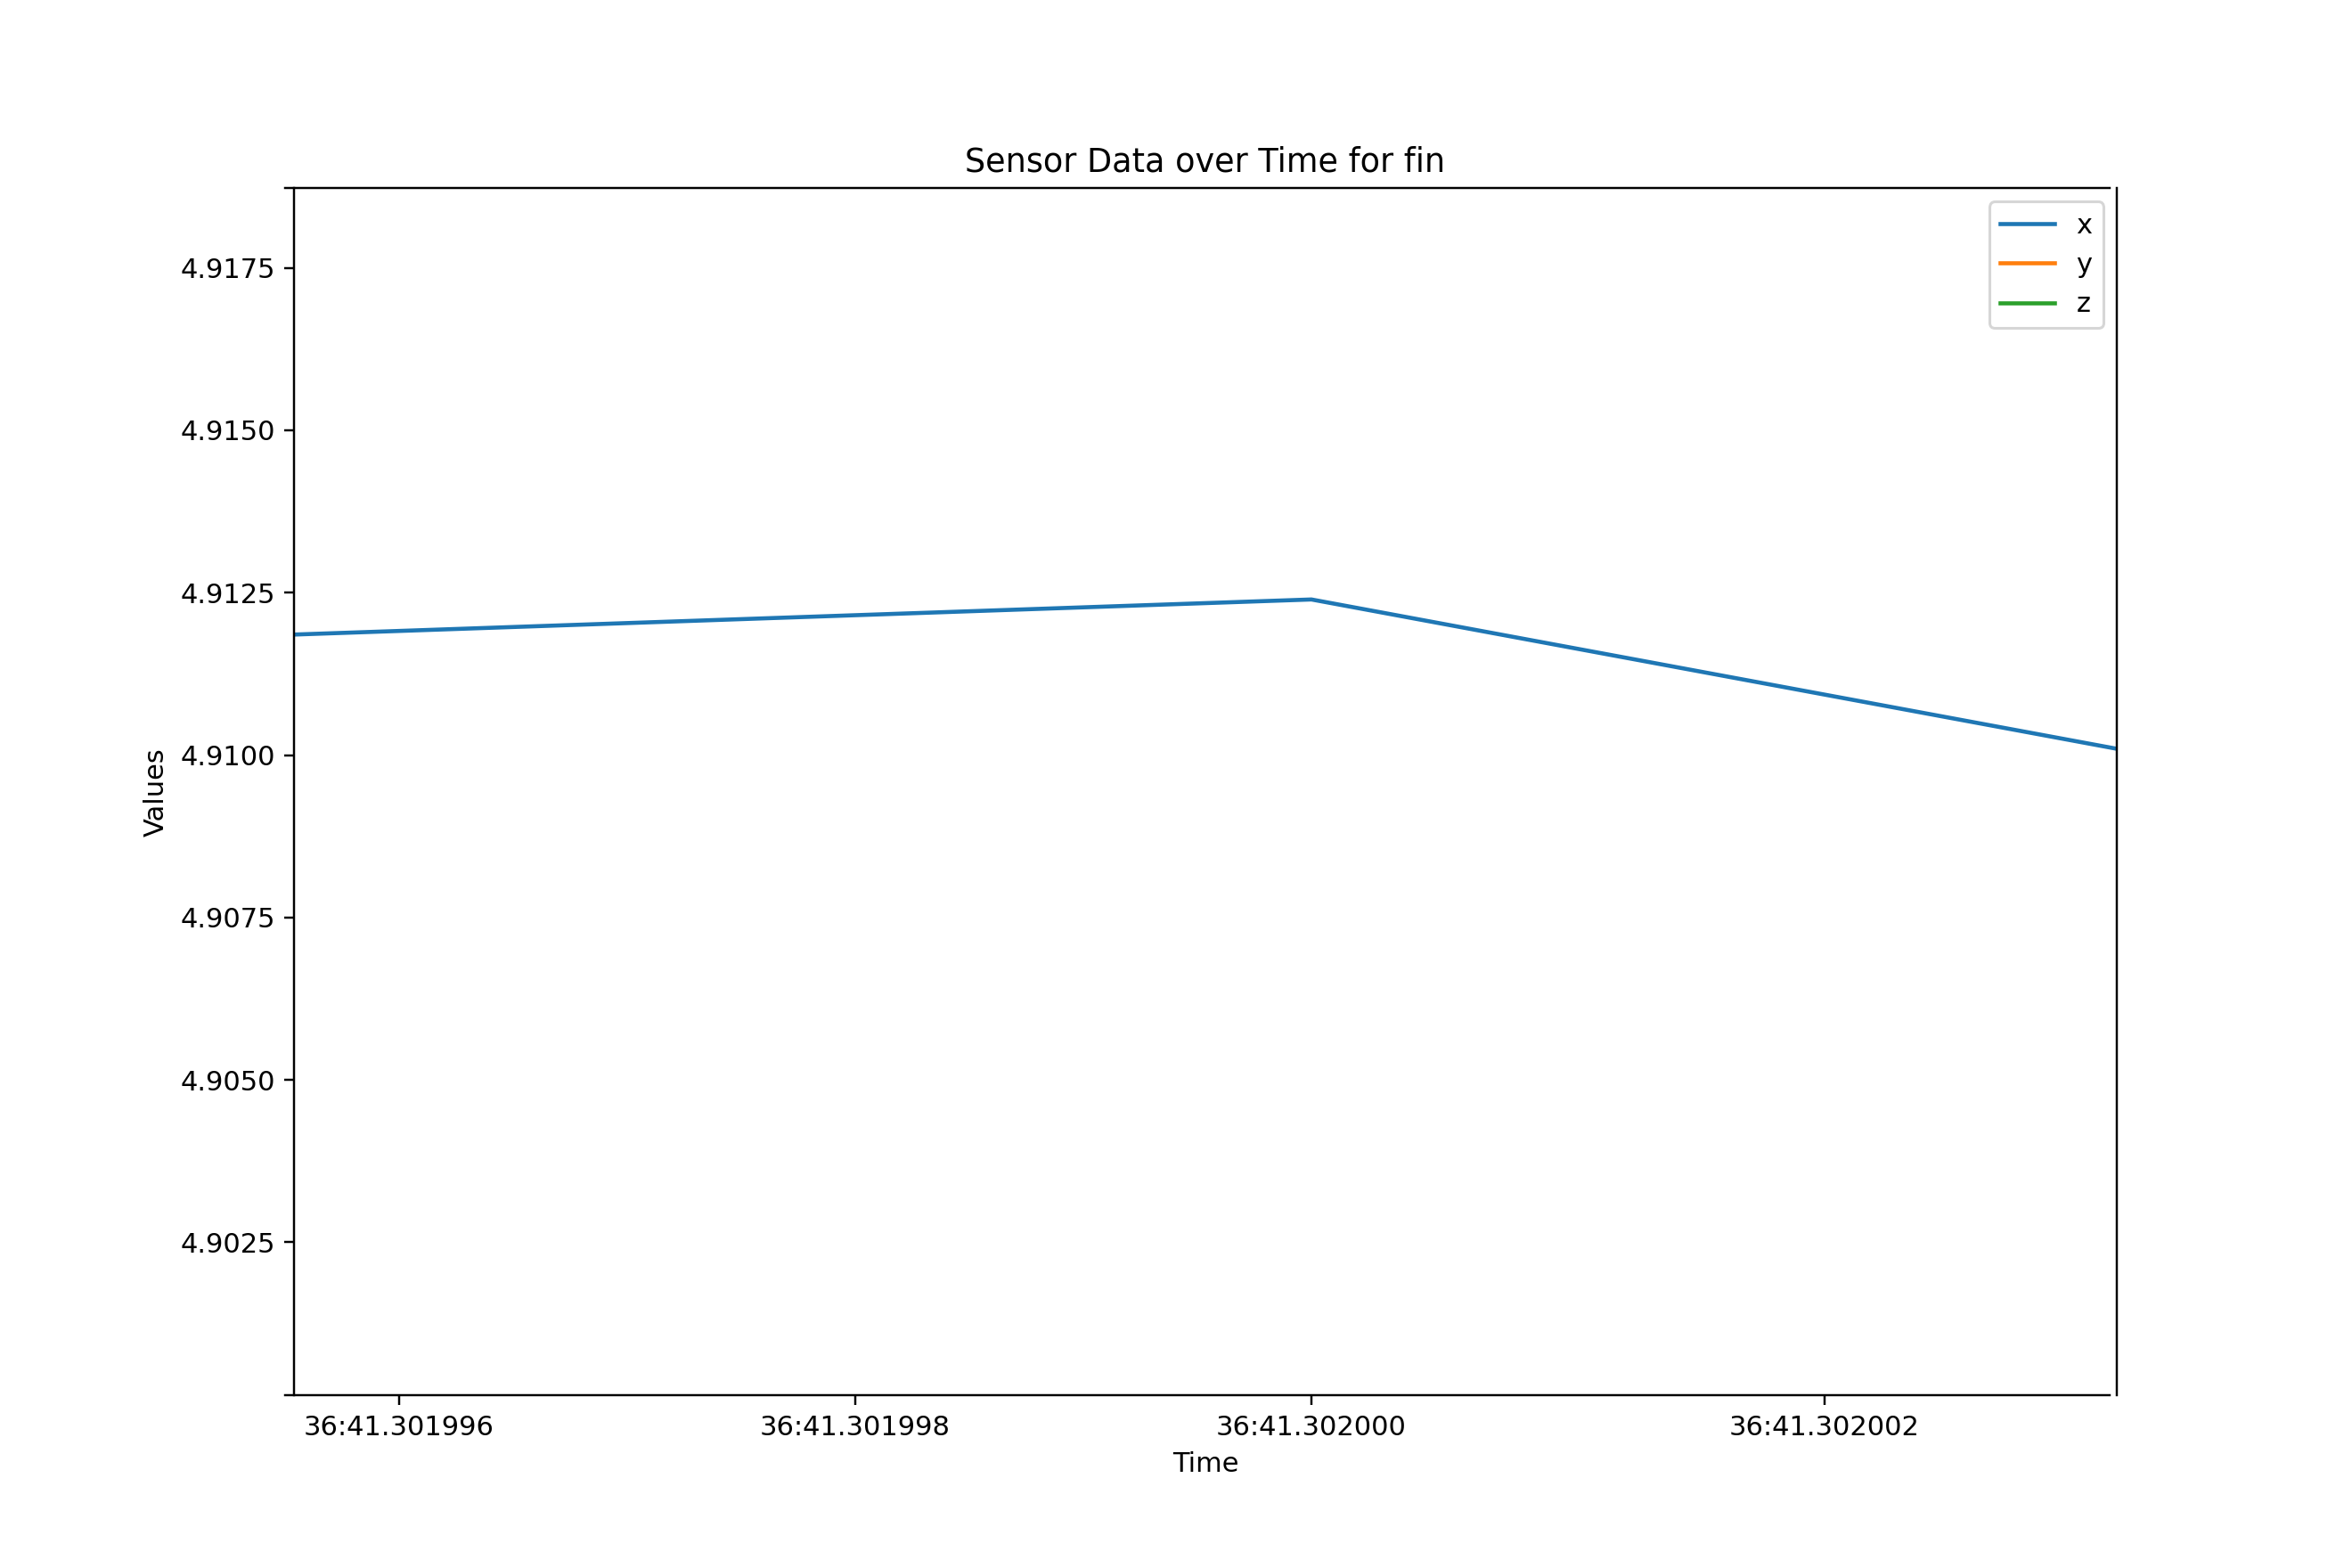

In [36]:
plot_raw_sensor([acc],"fin")

<IPython.core.display.Javascript object>


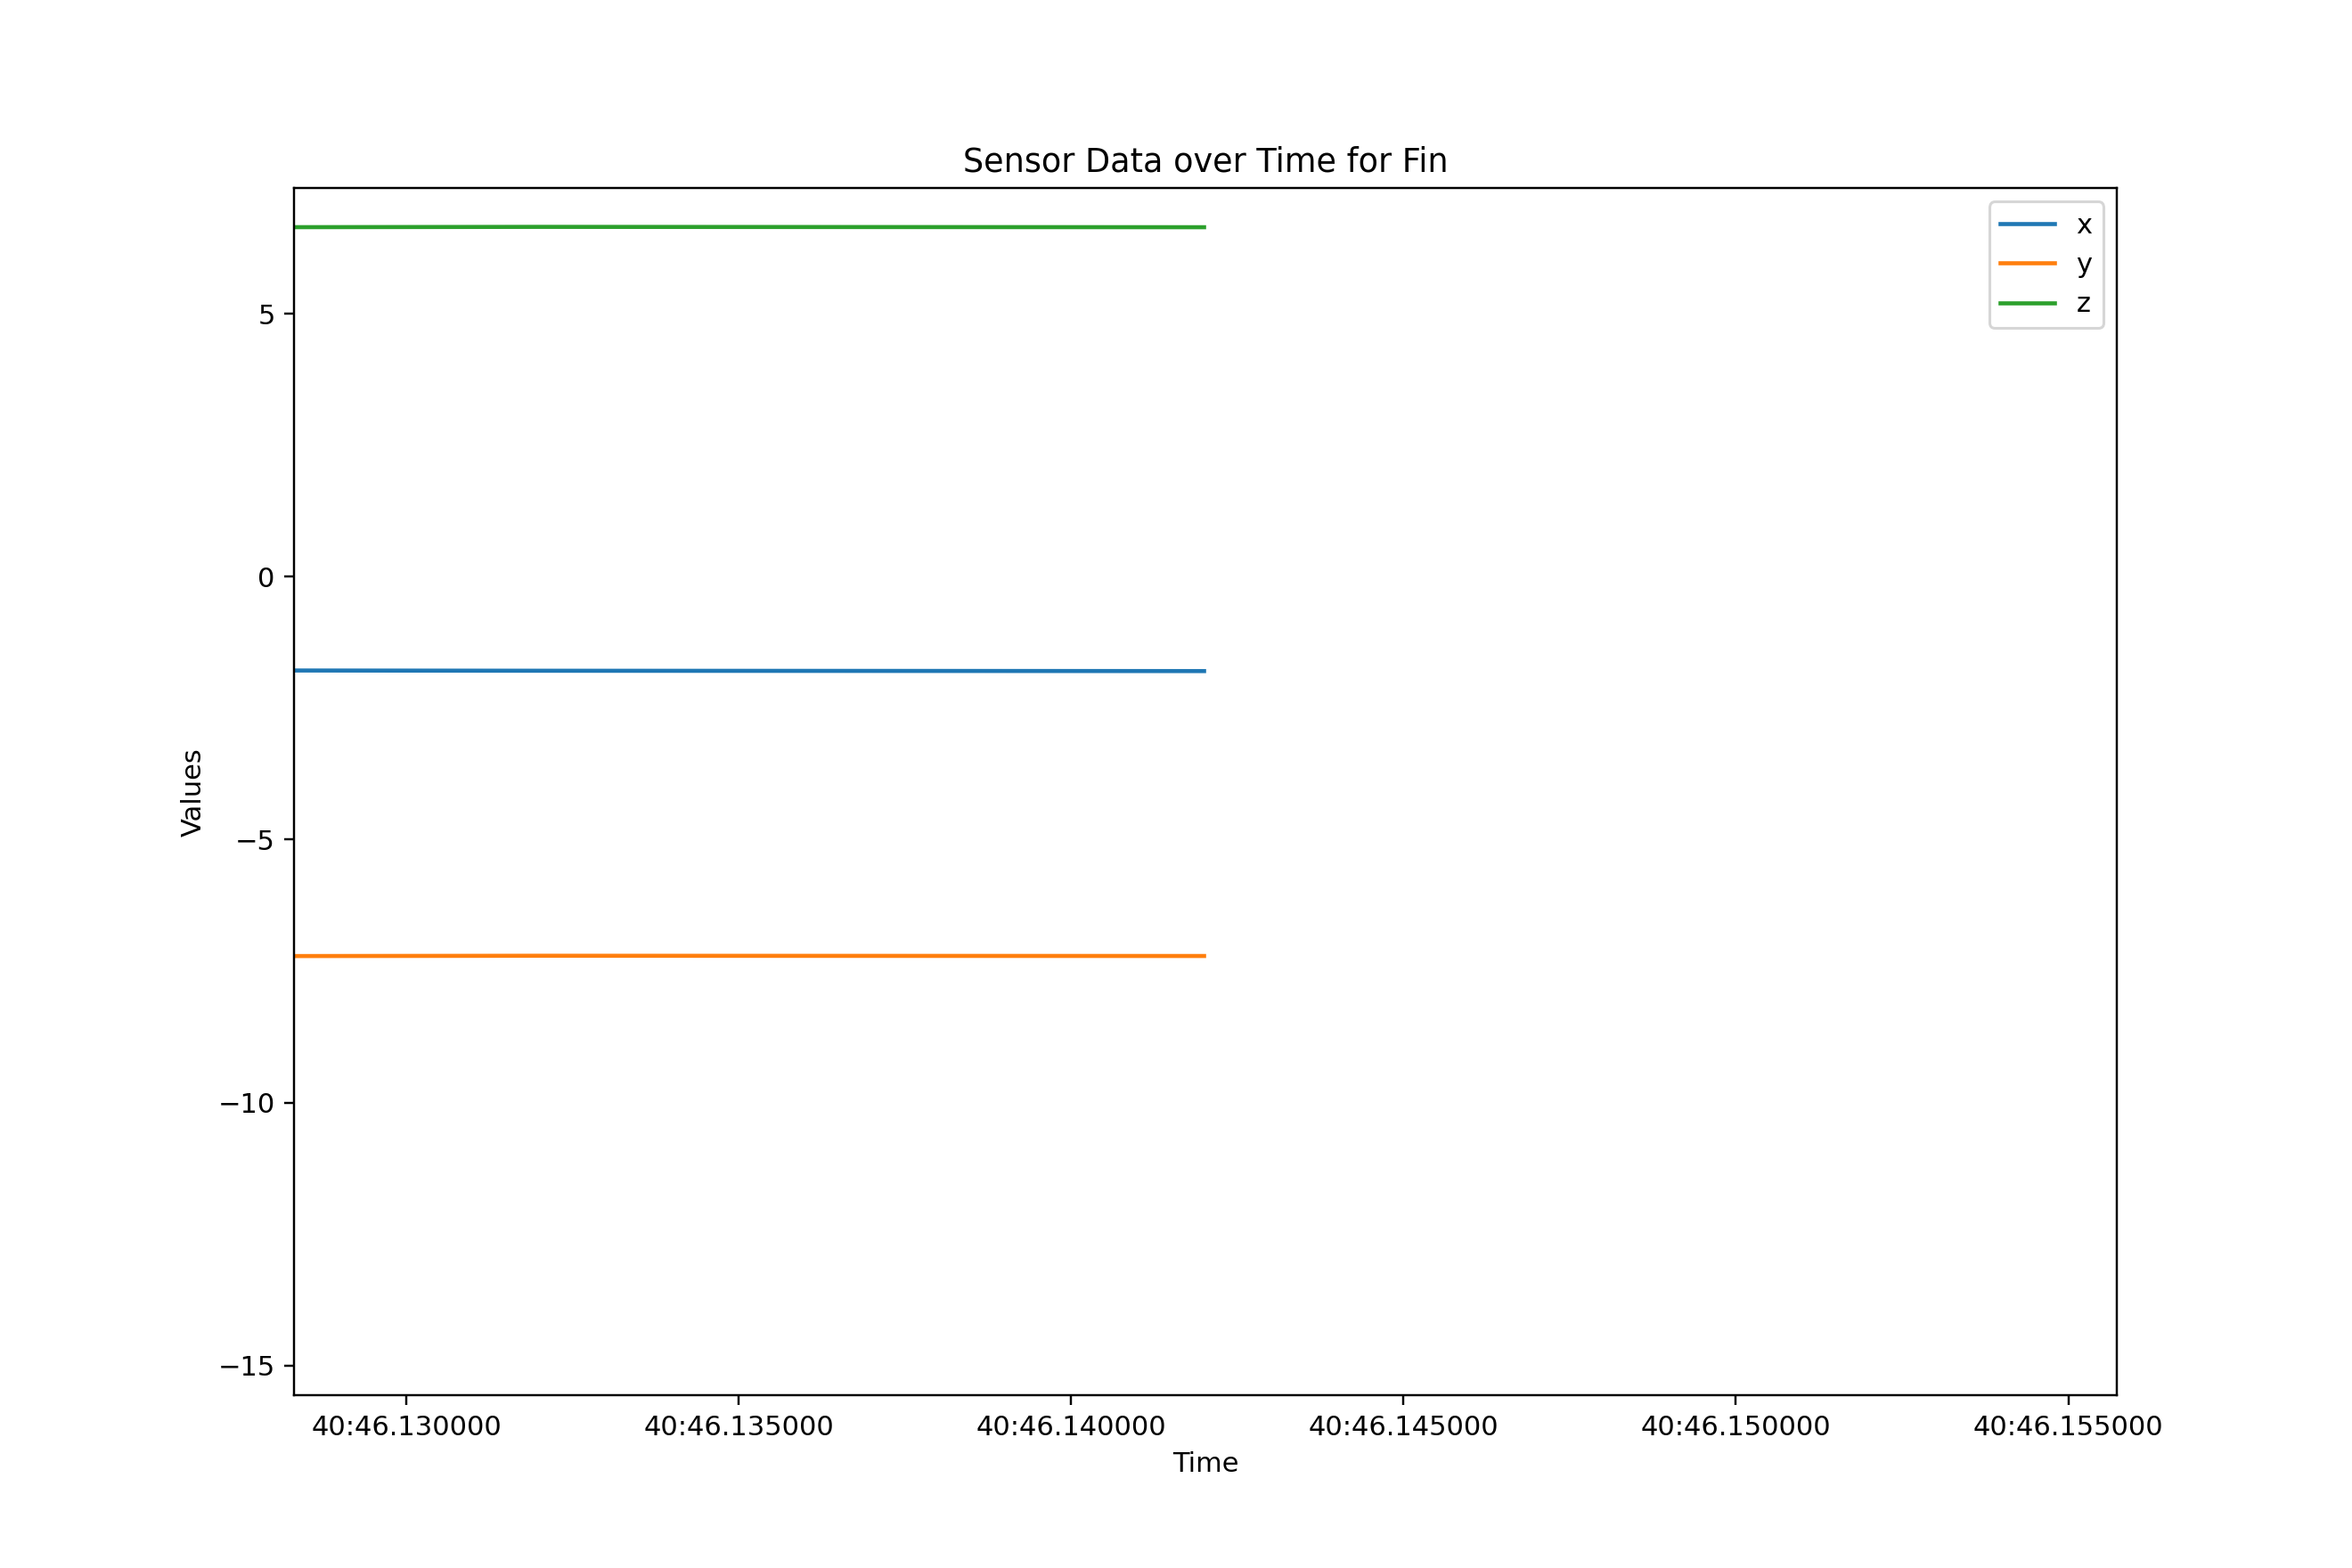

In [48]:
plot_raw_sensor([acc],"Fin")

In [38]:
print(calculate_frequency(acc))
print(calculate_frequency(gyro))


100.0
100.0


In [39]:
acc

,x,y,z,time
0,-0.808774,-9.982856,0.478565,2023-10-31 15:26:56.732
1,-0.800649,-9.903924,0.470439,2023-10-31 15:26:56.742
2,-0.792524,-9.824993,0.462314,2023-10-31 15:26:56.752
3,-0.840683,-9.912220,0.323326,2023-10-31 15:26:56.762
4,-0.892528,-10.010327,0.175767,2023-10-31 15:26:56.772
...,...,...,...,...
82937,-1.754164,-7.240179,6.619050,2023-10-31 15:40:46.102
82938,-1.765330,-7.232203,6.627026,2023-10-31 15:40:46.112
82939,-1.776496,-7.224227,6.635002,2023-10-31 15:40:46.122
82940,-1.789004,-7.208423,6.650806,2023-10-31 15:40:46.132


In [40]:
gyro

,x,y,z,time
0,-0.195378,0.051287,-0.023201,2023-10-31 15:26:56.732
1,-0.157454,0.048730,-0.022349,2023-10-31 15:26:56.742
2,-0.119532,0.046173,-0.021497,2023-10-31 15:26:56.752
3,-0.067255,0.041014,-0.029008,2023-10-31 15:26:56.762
4,-0.052987,0.037196,-0.051682,2023-10-31 15:26:56.772
...,...,...,...,...
82937,-0.001221,0.048059,0.007443,2023-10-31 15:40:46.102
82938,-0.001221,0.050325,0.005933,2023-10-31 15:40:46.112
82939,-0.001221,0.052590,0.004423,2023-10-31 15:40:46.122
82940,-0.001221,0.054855,0.002912,2023-10-31 15:40:46.132


In [43]:
atest, gtest = sync_and_resample_data(acc_data, gyro_data, 100)

<IPython.core.display.Javascript object>


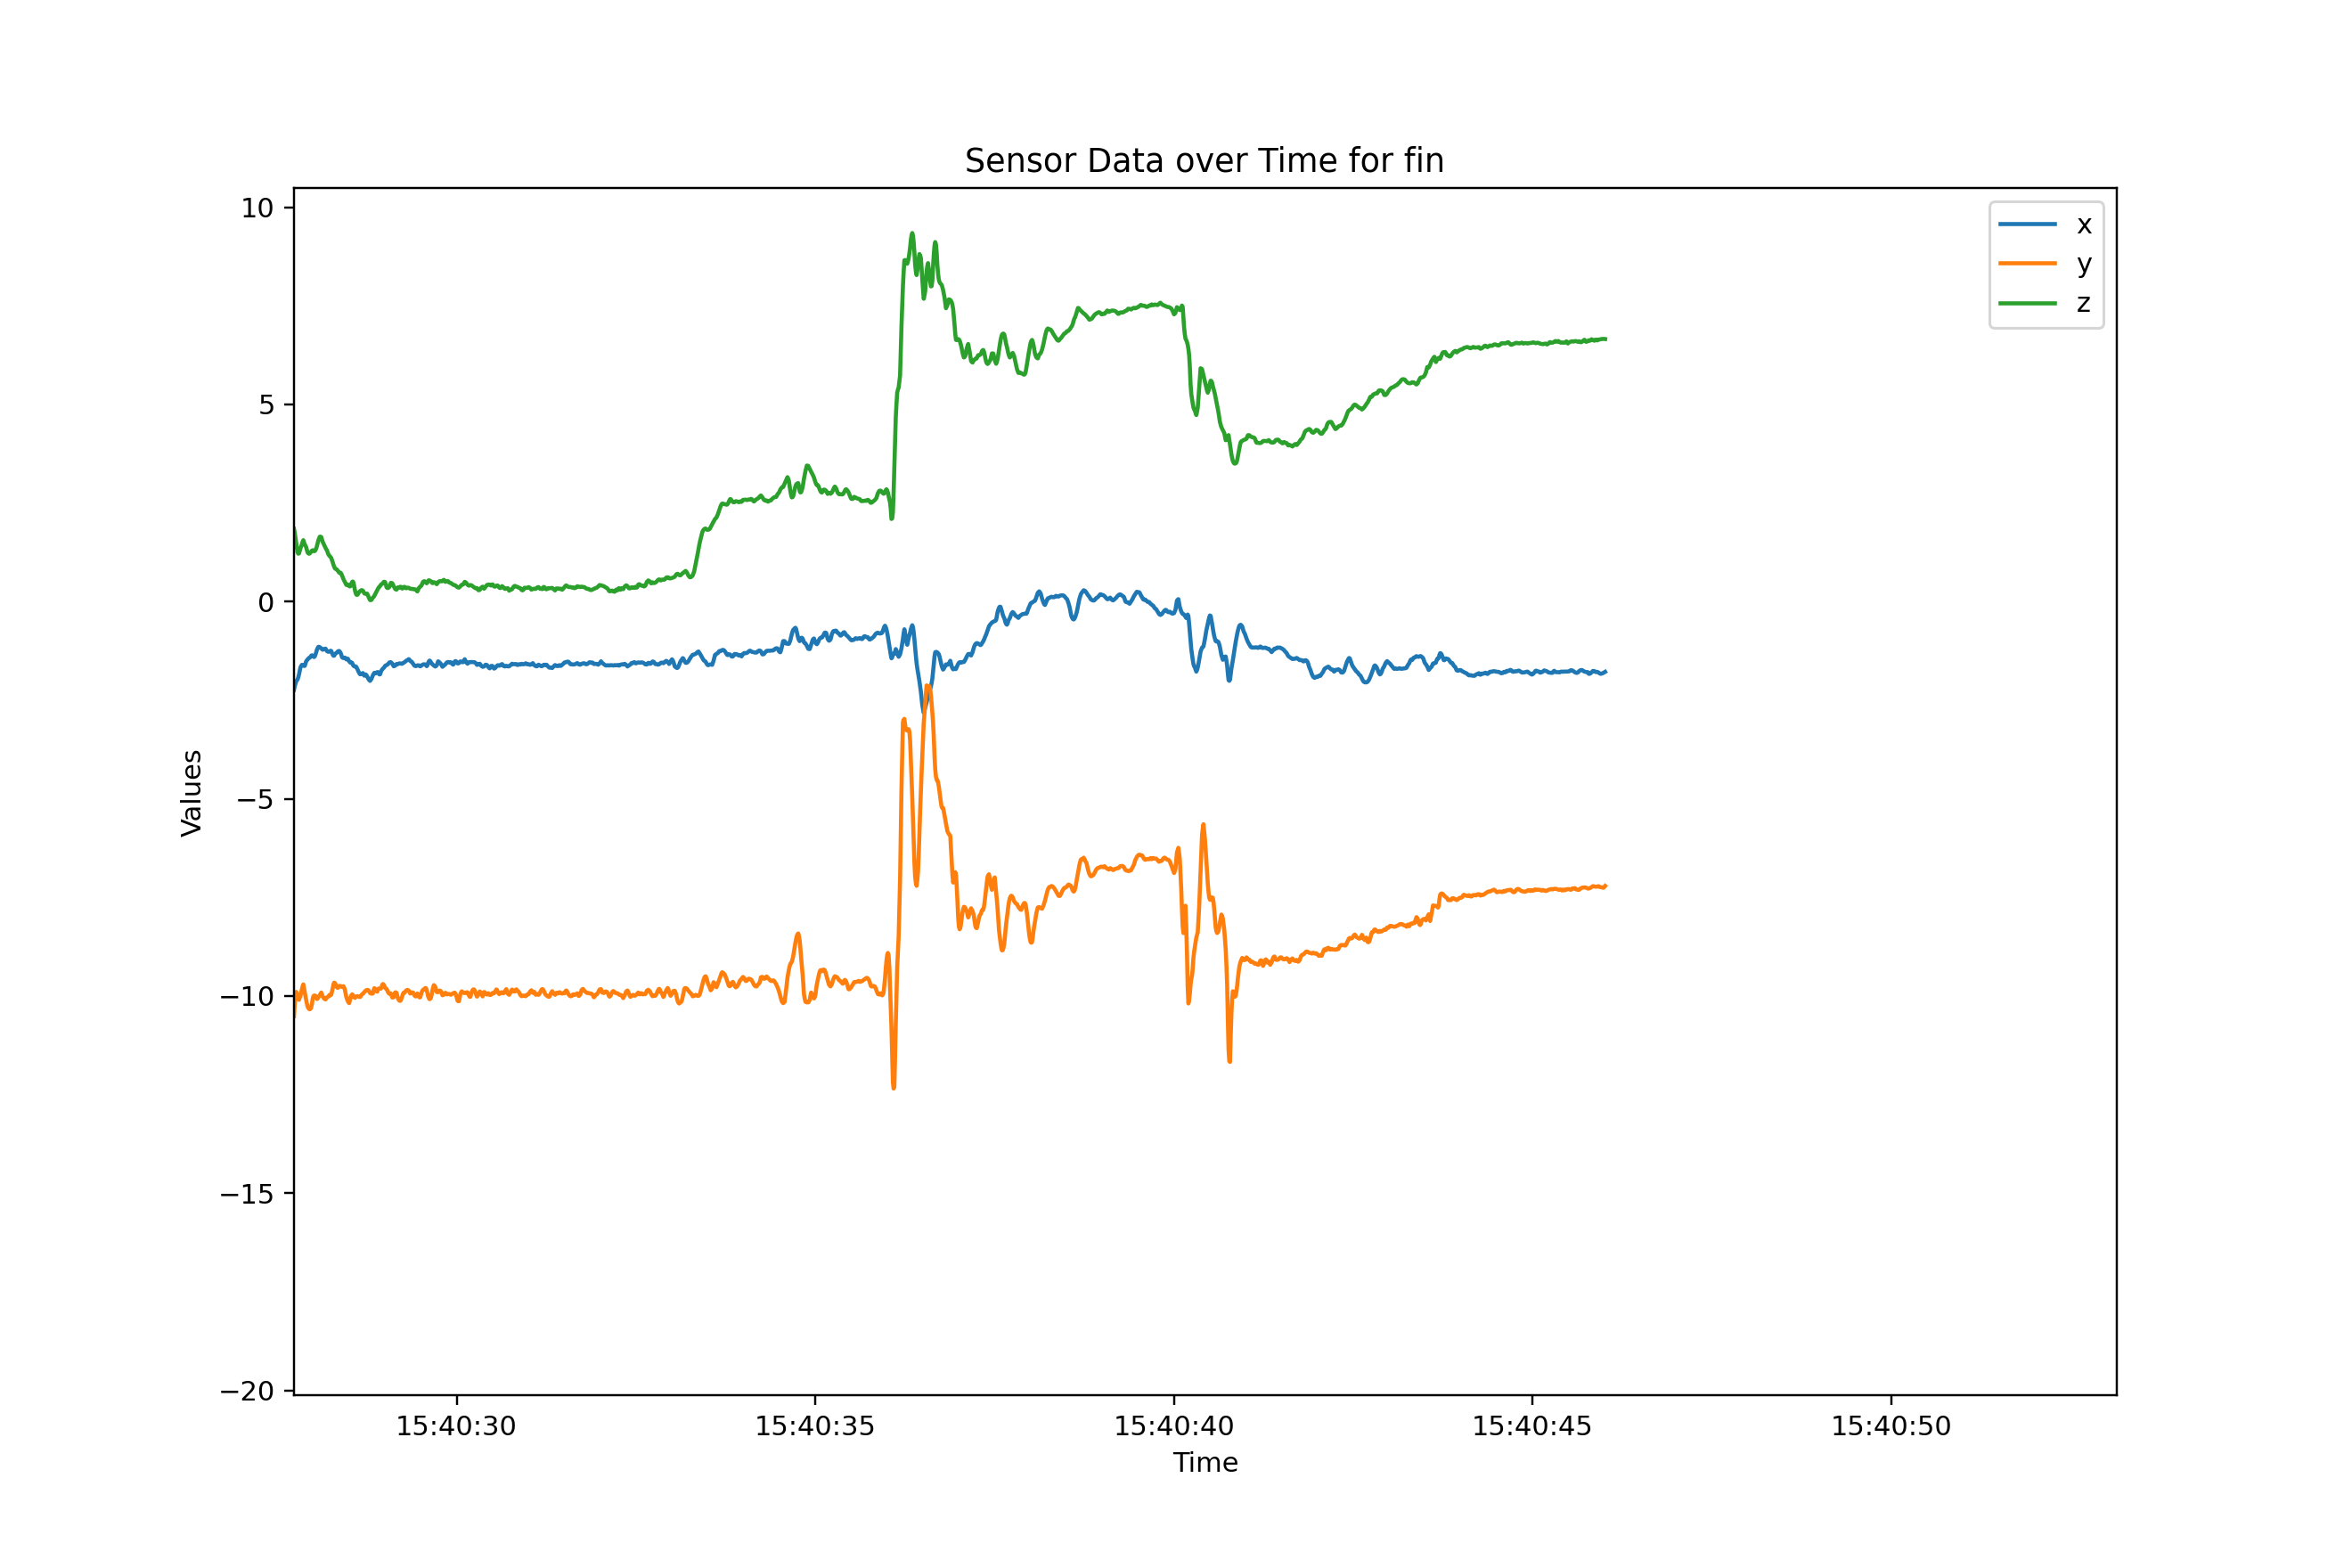

In [44]:
plot_raw_sensor([atest],"fin")

In [46]:
print(calculate_frequency(acc))
print(calculate_frequency(gyro))
atest


100.0
100.0


,x,y,z,time
0,-0.808774,-9.982856,0.478565,2023-10-31 15:26:56.732
1,-0.800649,-9.903924,0.470439,2023-10-31 15:26:56.742
2,-0.792524,-9.824993,0.462314,2023-10-31 15:26:56.752
3,-0.840683,-9.912220,0.323326,2023-10-31 15:26:56.762
4,-0.892528,-10.010327,0.175767,2023-10-31 15:26:56.772
...,...,...,...,...
82924,-1.819037,-7.249859,6.660373,2023-10-31 15:40:45.972
82925,-1.811061,-7.256240,6.661170,2023-10-31 15:40:45.982
82926,-1.801926,-7.251444,6.661618,2023-10-31 15:40:45.992
82927,-1.791304,-7.232325,6.661618,2023-10-31 15:40:46.002


In [47]:
gtest

,x,y,z,time
0,-0.195378,0.051287,-0.023201,2023-10-31 15:26:56.732
1,-0.157454,0.048730,-0.022349,2023-10-31 15:26:56.742
2,-0.119532,0.046173,-0.021497,2023-10-31 15:26:56.752
3,-0.067255,0.041014,-0.029008,2023-10-31 15:26:56.762
4,-0.052987,0.037196,-0.051682,2023-10-31 15:26:56.772
...,...,...,...,...
82924,-0.000699,0.020933,0.024074,2023-10-31 15:40:45.972
82925,-0.001221,0.021917,0.024036,2023-10-31 15:40:45.982
82926,-0.001221,0.023517,0.023503,2023-10-31 15:40:45.992
82927,-0.001221,0.025406,0.022545,2023-10-31 15:40:46.002
